<h1><center>Regression 1</center></h1>
<center>How well does Rotten Tomatoes score predict "best picture" at the Oscars?</center>

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from PIL import Image

from rotten_tomatoes.utils.regression import RegressionAnalysis

## Prepare data

In [2]:
data = pd.read_csv('../data/best_picture_data.csv')
data['review_score'] = data['review_score'].astype('float')

In [3]:
data.head()

,Unnamed: 0,year_film,category,movie_title,winner,rotten_tomatoes_link,critic_name,top_critic,review_type,review_score
0,0,1927,OUTSTANDING PICTURE,The Racket,False,m/racket,Dennis Schwartz,False,Rotten,73.0
1,2,1927,OUTSTANDING PICTURE,The Racket,False,m/racket,Bosley Crowther,True,Rotten,40.0
2,4,1927,OUTSTANDING PICTURE,The Racket,False,m/racket,NaN,False,Fresh,100.0
3,6,1927,OUTSTANDING PICTURE,The Racket,False,m/racket,Emanuel Levy,False,Rotten,78.0
4,8,1927,OUTSTANDING PICTURE,Wings,True,m/wings,James Berardinelli,True,Fresh,75.0


## Plot this data

In [4]:
import matplotlib.pyplot as plt

def plot_binned_data(data: pd.DataFrame, outfile: str=""): 
    bin_labels = ['80-100', '60-80', '40-60', '20-40', '0-20']
    data.loc[(data['review_score'] > 0 ) & (data['review_score'] <= 20), 'bin'] = '0-20'
    data.loc[(data['review_score'] > 20 ) & (data['review_score'] <= 40), 'bin'] = '20-40'
    data.loc[(data['review_score'] > 40 ) & (data['review_score'] <= 60), 'bin'] = '40-60'
    data.loc[(data['review_score'] > 60 ) & (data['review_score'] <= 80), 'bin'] = '60-80'
    data.loc[(data['review_score'] > 80 ) & (data['review_score'] <= 100), 'bin'] = '80-100'
    
    plot_data = data[['bin', 'winner']]
    plot_data = plot_data.value_counts().reset_index()
    plot_data.columns = ['bin', 'winner', 'counts']
    
    # Make data square 
    square_data = [(x, y) for x in bin_labels for y in [True, False]]
    square_data = pd.DataFrame(square_data, columns = ['bin', 'winner'])
    square_data['counts_square'] = 0
    plot_data = plot_data.merge(square_data, on=['bin', 'winner'], how='outer')
    plot_data.loc[plot_data['counts'].isna(), 'counts'] = plot_data.loc[plot_data['counts'].isna(), 'counts_square']
    
    N = 5
    yes_means = plot_data.loc[plot_data['winner']==True, 'counts']
    no_means = plot_data.loc[plot_data['winner']==False, 'counts']

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(ind, yes_means, width, color='g')
    ax.bar(ind + width, no_means, width, color='r')

    ax.set_ylabel('Number of ratings')
    ax.set_title('Ratings bins by Oscars win/loss')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(bin_labels)

    ax.legend(('Win', 'Loss'))
   
    if outfile:
        plt.savefig(outfile)
    
    plt.show()

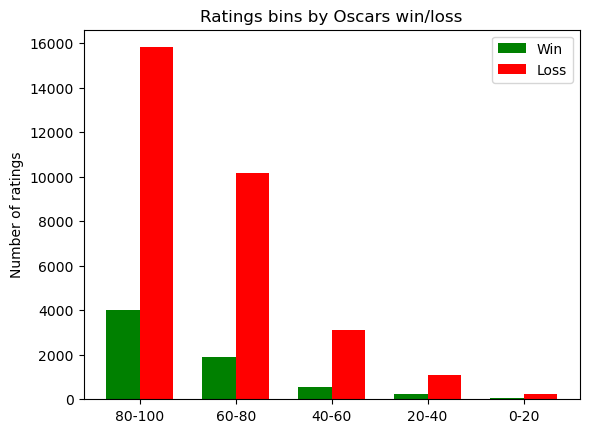

In [250]:
plot_binned_data(data, outfile='../images/ratings_bins_all.png')

This is telling me that a rotten tomatoes rating might not be a good predictor of an Oscars win. 
Maybe try reviewing some of these low-scoring Oscars wins by hand. 

In [5]:
data.loc[(data['winner']==True) & (data['review_score']<50)]

,Unnamed: 0,year_film,category,movie_title,winner,rotten_tomatoes_link,critic_name,top_critic,review_type,review_score
42,46,1928,OUTSTANDING PICTURE,The Broadway Melody,True,m/broadway_melody,Matt Easterbrook,False,Rotten,40.0
47,51,1928,OUTSTANDING PICTURE,The Broadway Melody,True,m/broadway_melody,"Michael W. Phillips, Jr.",False,Rotten,40.0
53,57,1928,OUTSTANDING PICTURE,The Broadway Melody,True,m/broadway_melody,Tim Brayton,False,Rotten,30.0
219,226,1941,OUTSTANDING MOTION PICTURE,How Green Was My Valley,True,m/how_green_was_my_valley,Rob Vaux,False,Rotten,40.0
234,241,1941,OUTSTANDING MOTION PICTURE,How Green Was My Valley,True,m/how_green_was_my_valley,Derek Smith,False,Rotten,37.5
...,...,...,...,...,...,...,...,...,...,...
37164,40653,2019,BEST PICTURE,Parasite,True,m/parasite_1982,Alex Sandell,False,Rotten,20.0
37165,40654,2019,BEST PICTURE,Parasite,True,m/parasite_1982,David Nusair,False,Rotten,0.0
37166,40655,2019,BEST PICTURE,Parasite,True,m/parasite_1982,Jake Euker,False,Rotten,20.0
37167,40656,2019,BEST PICTURE,Parasite,True,m/parasite_1982,Scott Weinberg,False,Rotten,30.0


In [6]:
value_counts = data.loc[(data['movie_title']=='American Beauty'), 'review_score'].value_counts().reset_index()
value_counts.columns = ['review_score', 'num_reviews']
value_counts = value_counts.sort_values('review_score', ascending=False)
value_counts

,review_score,num_reviews
0,100.0,47
4,95.0,9
12,94.0,1
15,92.0,1
3,90.0,9
6,88.0,4
1,87.5,11
11,85.0,1
2,80.0,11
5,75.0,7


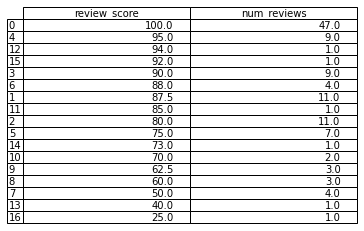

In [7]:
from pandas.plotting import table 

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False) # hide the x axis
ax.yaxis.set_visible(False) # hide the y axis

table(ax, value_counts, loc='center') 

plt.savefig('../images/american_beauty_scores.png')

It looks like just a few critics gave American Beauty a score below 50.
Maybe we would do better here if we averaged the rotten tomatoes score? 

In [8]:
data = data.groupby(['year_film', 'movie_title', 'winner'])['review_score'].mean().reset_index()
data.head()

,year_film,movie_title,winner,review_score
0,1927,The Racket,False,72.750000
1,1927,Wings,True,76.616667
2,1928,In Old Arizona,False,66.250000
3,1928,The Broadway Melody,True,54.892857
4,1928,The Patriot,False,68.560976


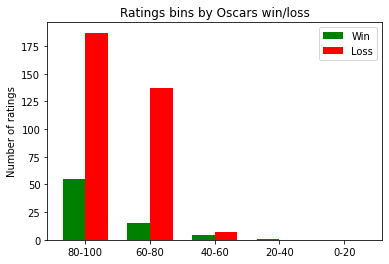

In [9]:
plot_binned_data(data, outfile='../images/ratings_bins_average.png')

## Run model

In [10]:
y = data['winner'].astype(int)

In [11]:
model = RegressionAnalysis(data[['review_score']], y, is_categorical=True)
model.set_X_cols(['review_score'])
model.fit_train()

In [12]:
model.model_.coef_

array([[0.02779508]])

In [13]:
model.predict_test()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Why is this only predicting losses? 

In [14]:
data.head()

,year_film,movie_title,winner,review_score,bin
0,1927,The Racket,False,72.750000,60-80
1,1927,Wings,True,76.616667,60-80
2,1928,In Old Arizona,False,66.250000,60-80
3,1928,The Broadway Melody,True,54.892857,40-60
4,1928,The Patriot,False,68.560976,60-80


In [15]:
y[0:5]

0    0
1    1
2    0
3    1
4    0
Name: winner, dtype: int64

In [16]:
data.winner.value_counts()

False    331
True      75
Name: winner, dtype: int64

## Try setting the class weight parameter to "balanced". This should give a higher penalty for predicting a loss incorrectly. 

In [17]:
model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights='balanced')
model.set_X_cols(['review_score'])
model.fit_train()

In [18]:
model.model_.coef_

array([[0.02087762]])

In [19]:
model.predict_test()

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [20]:
# Okay, this is too strong!
# Let's try some custom dictionaries of weights. 
weights = {1: 4, 0: 1} # Give a win a weight of 4, versus a weight of 1 for a loss. 
model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights=weights)
model.set_X_cols(['review_score'])
model.fit_train()

model.model_.coef_

array([[0.02107082]])

In [21]:
model.predict_test()

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [22]:
weights = {1: 2, 0: 1} # A weight of 4 is too strong - try a weight of 2.
model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights=weights)
model.set_X_cols(['review_score'])
model.fit_train()

model.predict_test()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
# A weight of 2 is too light. 
# Write an algorithm to find the best weight for a win in .10 increments between 2 and 4.
weights_to_test = np.arange(2, 4, .10)
weights_to_test

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
       3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9])

In [24]:
# Our scoring algorithm will be: 
# 1. You must predict at least one win for all input data 
# 2. Take the model with the highest accuracy. 
results = {}
for weight in weights_to_test:
    weights = {1: weight, 0: 1} # 'Loss' class always stays at 1
    model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights=weights)
    model.set_X_cols(['review_score'])
    model.fit_train()
    
    preds = model.predict_test()
    
    results[weight] = {
        'any_win': any(preds > 0),
        'accuracy': model.score_test()
    }

In [25]:
results

{2.0: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.1: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.2: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.3000000000000003: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.4000000000000004: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.5000000000000004: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.6000000000000005: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.7000000000000006: {'any_win': False, 'accuracy': 0.8431372549019608},
 2.8000000000000007: {'any_win': True, 'accuracy': 0.8333333333333334},
 2.900000000000001: {'any_win': True, 'accuracy': 0.8431372549019608},
 3.000000000000001: {'any_win': True, 'accuracy': 0.8333333333333334},
 3.100000000000001: {'any_win': True, 'accuracy': 0.8137254901960784},
 3.200000000000001: {'any_win': True, 'accuracy': 0.803921568627451},
 3.300000000000001: {'any_win': True, 'accuracy': 0.803921568627451},
 3.4000000000000012: {'any_win': Tru

This is interesting. Find the value where at least one win is predicted, and compare it to when no wins are predicted. 

In [26]:
crossover_value = 0
for k, v in results.items():
    if v['any_win'] == True:
        crossover_value = k
        break
print(f"Found crossover value {crossover_value}!")

Found crossover value 2.8000000000000007!


In [27]:
weights = {1: crossover_value, 0: 1} # 'Loss' class always stays at 1
any_win_model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights=weights)
any_win_model.set_X_cols(['review_score'])
any_win_model.fit_train()

any_win_accuracy = any_win_model.score_test()

In [28]:
weights = {1: 1, 0: 1} # 'Loss' class always stays at 1
no_win_model = RegressionAnalysis(data[['review_score']], y, is_categorical=True, class_weights=weights)
no_win_model.set_X_cols(['review_score'])
no_win_model.fit_train()

preds = no_win_model.predict_test()

assert all(preds ==0)
no_win_accuracy_score = no_win_model.score_test()

In [29]:
print(f"Any win model has accuracy of {round(any_win_accuracy, 5)} "
      f"and a regression coefficient of {any_win_model.model_.coef_}, "
      f"while no-win model has accuracy of {round(no_win_accuracy_score, 5)} and "
     f"a coefficient of {no_win_model.model_.coef_}.")

Any win model has accuracy of 0.83333 and a regression coefficient of [[0.02294634]], while no-win model has accuracy of 0.84314 and a coefficient of [[0.02779508]].


This tells us that rotten tomatoes score is not a very good predictor of a best picture Oscars win, and that no matter how you tune the logistic regression you will always get better accuracy by predicting all losses. 